In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda


# Generate dataset

In [2]:
np.random.seed(12)
y = np.random.randint(0,3,5000)
idx= []
for i in range(3):
    print(i,sum(y==i))
    idx.append(y==i)

0 1703
1 1677
2 1620


In [3]:
x = np.zeros((5000,))

In [4]:
np.random.seed(12)
x[idx[0]] = np.random.uniform(low =-1,high =0,size= sum(idx[0]))
x[idx[1]] = np.random.uniform(low =0,high =1,size= sum(idx[1]))
x[idx[2]] = np.random.uniform(low =2,high =3,size= sum(idx[2]))

In [5]:
x[idx[0]][0], x[idx[2]][5] 

(-0.8458371576203276, 2.536741188595152)

In [6]:
print(x.shape,y.shape)

(5000,) (5000,)


In [7]:
idx= []
for i in range(3):
  idx.append(y==i)

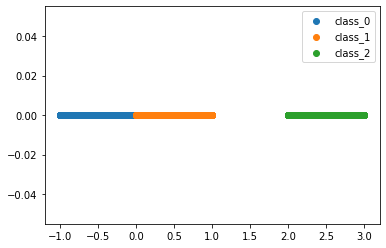

In [8]:
for i in range(3):
    y= np.zeros(x[idx[i]].shape[0])
    plt.scatter(x[idx[i]],y,label="class_"+str(i))
plt.legend()

In [9]:
bg_idx = [ np.where(idx[2] == True)[0]]

bg_idx = np.concatenate(bg_idx, axis = 0)
bg_idx.shape

(1620,)

In [10]:
np.unique(bg_idx).shape

(1620,)

In [11]:
# x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)


In [12]:
# np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True)

In [13]:
# x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

In [14]:
# np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True)

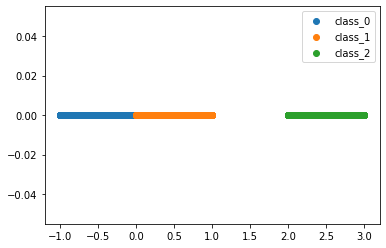

In [15]:
for i in range(3):
    y= np.zeros(x[idx[i]].shape[0])
    plt.scatter(x[idx[i]],y,label="class_"+str(i))
plt.legend()

In [16]:
foreground_classes = {'class_0','class_1' }

background_classes = {'class_2'}

In [17]:
# fg_class  = np.random.randint(0,2)
# fg_idx = np.random.randint(0,9)

# a = []
# for i in range(9):
#     if i == fg_idx:
#         b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
#         a.append(x[b])
#         print("foreground "+str(fg_class)+" present at " + str(fg_idx))
#     else:
#         bg_class = np.random.randint(2,3)
#         b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
#         a.append(x[b])
#         print("background "+str(bg_class)+" present at " + str(i))
# a = np.concatenate(a,axis=0)
# print(a.shape)

# print(fg_class , fg_idx)

In [18]:
# a.shape

In [19]:
# np.reshape(a,(9,1))

In [20]:
# a=np.reshape(a,(3,3))

In [21]:
# plt.imshow(a)

In [22]:
desired_num = 20000
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    np.random.seed(j)
    fg_class  = np.random.randint(0,2)
    fg_idx = np.random.randint(0,9)
    a = []
    for i in range(9):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(2,3)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(9,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [23]:
mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T


In [24]:
mosaic_list_of_images.shape, mosaic_list_of_images[0]

((20000, 9),
 array([ 2.57383607,  2.74792999,  2.64740665,  2.68100263,  2.25277891,
        -0.39131949,  2.17435623,  2.40378039,  2.02468417]))

In [25]:
for j in range(9):
  print(mosaic_list_of_images[1][j])
  

2.388687880796558
2.3807168997738155
2.018097375943883
2.7039373167343776
2.197069764484894
2.075070857999611
2.1596484472843214
2.569785999638043
0.6042359616682469


In [26]:
fore_idx[1],mosaic_label[1]

(8, 1)

In [27]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]



In [28]:
batch = 10000
msd1 = MosaicDataset(mosaic_list_of_images[0:10000], mosaic_label[0:10000] , fore_idx[0:10000])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

In [29]:
batch = 10000
msd2 = MosaicDataset(mosaic_list_of_images[10000:20000], mosaic_label[10000:20000] , fore_idx[10000:20000])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

In [30]:
class Focus(nn.Module):
  def __init__(self):
    super(Focus, self).__init__()

    self.fc1 = nn.Linear(1, 1, bias= False)
    # self.fc2 = nn.Linear(2, 1)

  def forward(self,z):  #y is avg image #z batch of list of 9 images
    y = torch.zeros([batch], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = y.to("cuda")
    x = x.to("cuda")
    for i in range(9):
      x[:,i] = self.helper(z[:,i])[:,0]

    x = F.softmax(x,dim=1)

    for i in range(9):            
      # x1 = x[:,i]          
      y = y + torch.mul(x[:,i],z[:,i])

    # print(x.shape, y.shape)
    return x, y
    
  def helper(self, x):
    x = x.view(-1, 1)
    # x = F.relu(self.fc1(x))
    x = (self.fc1(x))

    return x

In [31]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.fc1 = nn.Linear(1, 1)


  def forward(self, x):
    x = x.view(-1, 1)
    x = self.fc1(x)
    # print(x.shape)
    return x

In [32]:
import torch.optim as optim

def train(train_loader, test_loader, focus_net, classify):    
  criterion = nn.BCEWithLogitsLoss()
  #optimizer_classify = optim.SGD(classify.parameters(), lr=0.01 ) #, momentum=0.9)
  optimizer_focus = optim.SGD(focus_net.parameters(), lr=0.01 ) #, momentum=0.9)

  print('-'*50)
  print(focus_net.fc1.weight, classify.fc1.weight, classify.fc1.bias)
  nos_epochs = 3000
  loss_ret=0.0
  every_what_epoch = 1

  for epoch in range(nos_epochs):  # loop over the dataset multiple times
    
    running_loss = 0.0
    epoch_loss = []
    cnt=0

    iteration = desired_num // batch
    
    #training data set
    #if ((epoch) % (every_what_epoch*2) ) <= every_what_epoch-1 :
      #print(epoch+1,"updating focus_net, classify_net is freezed")
      #print("--"*40)
    # elif ((epoch) % (every_what_epoch*2)) > every_what_epoch-1 :
    #   print(epoch+1,"updating classify_net, focus_net is freezed")
    #   print("--"*40)    
    for i, data in  enumerate(train_loader):
      #print(i)
      inputs , labels , fore_idx = data
      inputs, labels = inputs.to("cuda"), labels.to("cuda")
      inputs = inputs.double()
      labels = labels.float()
      # zero the parameter gradients
      
      optimizer_focus.zero_grad()
      #optimizer_classify.zero_grad()
      
      alphas, avg_images = focus_net(inputs)
      outputs = classify(avg_images)

      predicted = np.round(torch.sigmoid(outputs.data).cpu().numpy())

      loss = criterion(outputs[:,0], labels) 
      loss.backward()
      if ((epoch) % (every_what_epoch*2) ) <= every_what_epoch-1 :
        optimizer_focus.step()
      # elif ( (epoch) % (every_what_epoch*2)) > every_what_epoch-1 :
      #   optimizer_classify.step()

      running_loss += loss.item()
      # mini = 3
      # if cnt % mini == mini-1 :    # print every 40 mini-batches
      epoch_loss.append(running_loss)
      running_loss = 0.0
      cnt=cnt+1
    loss_ret = np.mean(epoch_loss)
    if(epoch%200==0):
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, np.mean(epoch_loss)))
    if(np.mean(epoch_loss) <= 0.01):
        break;

  with torch.no_grad():
    focus_true_pred_true =0
    focus_false_pred_true =0
    focus_true_pred_false =0
    focus_false_pred_false =0

    argmax_more_than_half = 0
    argmax_less_than_half =0
    for data in test_loader:
      inputs, labels , fore_idx = data
      inputs = inputs.double()
      inputs, labels = inputs.to("cuda"), labels.to("cuda")
      alphas, avg_images = focus_net(inputs)
      outputs = classify(avg_images)
      predicted = np.round(torch.sigmoid(outputs.data).cpu().numpy())

      for j in range (batch):
        focus = torch.argmax(alphas[j])

        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j].item()):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j].item()):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j].item()):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j].item()):
          focus_false_pred_false +=1

  print('Finished Training')  
  return loss_ret, argmax_more_than_half/100, focus_true_pred_true/100, focus_false_pred_true/100, focus_true_pred_false/100 , focus_false_pred_false/100, focus_net.fc1.weight.item(), classify.fc1.weight.item(), classify.fc1.bias.item()
    


In [33]:
a =  [0.]
b = [-10.,-5.,-2.,0.,2.,5.,10.]
c = [-10.,-5.,-2.,0.,2.,5.,10.]

In [34]:
all_loss=[]
# all_alphas_more_than_half=[]
all_ftpt=[]
all_ffpt=[]
all_ftpf = []
all_ffpf= []
init_a = []
init_b = []
init_c = []
final_a=[]
final_b = []
final_c = []

for a1 in a:
  for b1 in b:
    for c1 in c:
      print("for a value %.3f, b value %.3f, and c value %.3f " %(a1,b1,c1))
      print("*"*70)
      torch.manual_seed(12)
      focus_net = Focus().double()
      focus_net.fc1.weight = torch.nn.Parameter(torch.tensor(np.array([[a1]])))
      torch.manual_seed(12)
      classify = Classification().double()
      classify.fc1.weight = torch.nn.Parameter(torch.tensor(np.array([[b1]])))
      classify.fc1.bias = torch.nn.Parameter(torch.tensor(np.array([c1])))
      focus_net = focus_net.to("cuda")
      classify = classify.to("cuda")
      print("--"*40,"a,b,c = ",a1,b1,c1)
      cost, alpha_per, ftpt, ffpt, ftpf, ffpf, f_a, f_b, f_c = train(train_loader, test_loader, focus_net, classify)
      print(cost, alpha_per, ftpt, ffpt, ftpf, ffpf)
      init_a.append(a1)
      init_b.append(b1)
      init_c.append(c1)
      final_a.append(np.round(f_a,3))
      final_b.append(np.round(f_b,3))
      final_c.append(np.round(f_c,3))
      all_loss.append(np.round(cost,3))
      # all_alphas_more_than_half.append(alpha_per)
      all_ftpt.append(ftpt)
      all_ffpt.append(ffpt)
      all_ftpf.append(ftpf)
      all_ffpf.append(ffpf)



for a value 0.000, b value -10.000, and c value -10.000 
**********************************************************************
-------------------------------------------------------------------------------- a,b,c =  0.0 -10.0 -10.0
--------------------------------------------------
Parameter containing:
tensor([[0.]], device='cuda:0', dtype=torch.float64, requires_grad=True) Parameter containing:
tensor([[-10.]], device='cuda:0', dtype=torch.float64, requires_grad=True) Parameter containing:
tensor([-10.], device='cuda:0', dtype=torch.float64, requires_grad=True)
[1,     2] loss: 16.403
[201,     2] loss: 8.049
[401,     2] loss: 7.726
[601,     2] loss: 7.641
[801,     2] loss: 7.601
[1001,     2] loss: 7.579
[1201,     2] loss: 7.564
[1401,     2] loss: 7.553
[1601,     2] loss: 7.545
[1801,     2] loss: 7.539
[2001,     2] loss: 7.535
[2201,     2] loss: 7.531
[2401,     2] loss: 7.527
[2601,     2] loss: 7.525
[2801,     2] loss: 7.522
Finished Training
7.5201311111450195 100.0 4

In [35]:
# df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [36]:
columns = ["init_a", "init_b", "init_c", "final_a", "final_b", "final_c", "train_loss", "argmax > 0.5" , "ftpt", "ffpt", "ftpf", "ffpf" ]

In [37]:
df_test[columns[0]] = init_a
df_test[columns[1]] = init_b
df_test[columns[2]] = init_c
df_test[columns[3]] = final_a
df_test[columns[4]] = final_b
df_test[columns[5]] = final_c
df_test[columns[6]] = all_loss
# df_test[columns[7]] = all_alphas_more_than_half
df_test[columns[8]] = all_ftpt
df_test[columns[9]] = all_ffpt
df_test[columns[10]] = all_ftpf
df_test[columns[11]] = all_ffpf

In [38]:
df_test

,init_a,init_b,init_c,final_a,final_b,final_c,train_loss,ftpt,ffpt,ftpf,ffpf
0,0.0,-10.0,-10.0,-4.490,-10.0,-10.0,7.520,49.02,0.00,50.98,0.00
1,0.0,-10.0,-5.0,-4.477,-10.0,-5.0,5.663,24.68,0.00,75.32,0.00
2,0.0,-10.0,-2.0,-4.453,-10.0,-2.0,5.126,10.42,0.00,89.58,0.00
3,0.0,-10.0,0.0,-4.418,-10.0,0.0,5.021,0.04,0.00,99.96,0.00
4,0.0,-10.0,2.0,-4.345,-10.0,2.0,5.124,10.55,0.00,89.45,0.00
5,0.0,-10.0,5.0,-0.898,-10.0,5.0,6.154,26.46,0.00,73.54,0.00
6,0.0,-10.0,10.0,-0.621,-10.0,10.0,4.606,32.47,0.00,67.53,0.00
7,0.0,-5.0,-10.0,-4.035,-5.0,-10.0,6.259,49.02,0.00,50.98,0.00
8,0.0,-5.0,-5.0,-4.030,-5.0,-5.0,3.835,49.02,0.00,50.98,0.00
9,0.0,-5.0,-2.0,-3.991,-5.0,-2.0,2.852,20.00,0.00,80.00,0.00


In [39]:
# df_test.to_csv("linear_linear_altmin_focus_first.csv")

In [40]:
#df_train.to_csv("train_1.csv")
df_test.to_csv("test_2.csv")

In [41]:
loss_heat_map = np.zeros((7,7))

In [42]:
loss_heat_map[0,:] = df_test[df_test.init_b == -10].train_loss
loss_heat_map[1,:] = df_test[df_test.init_b == -5].train_loss
loss_heat_map[2,:] = df_test[df_test.init_b == -2].train_loss
loss_heat_map[3,:] = df_test[df_test.init_b == 0].train_loss
loss_heat_map[4,:] = df_test[df_test.init_b == 2].train_loss
loss_heat_map[5,:] = df_test[df_test.init_b == 5].train_loss
loss_heat_map[6,:] = df_test[df_test.init_b == 10].train_loss


In [43]:
loss_heat_map

array([[7.52 , 5.663, 5.126, 5.021, 5.124, 6.154, 4.606],
       [6.259, 3.835, 2.852, 2.653, 3.298, 2.421, 1.001],
       [5.525, 3.034, 1.721, 1.374, 1.22 , 0.691, 2.373],
       [5.005, 2.509, 1.128, 0.693, 1.126, 2.504, 4.995],
       [2.378, 0.681, 0.319, 0.319, 0.714, 2.028, 4.513],
       [0.402, 0.146, 0.128, 0.156, 0.375, 1.357, 3.776],
       [0.072, 0.064, 0.067, 0.081, 0.197, 0.733, 2.585]])

Text(0.5, 1.0, 'Minimizing a for fix value of b and c,loss values here')

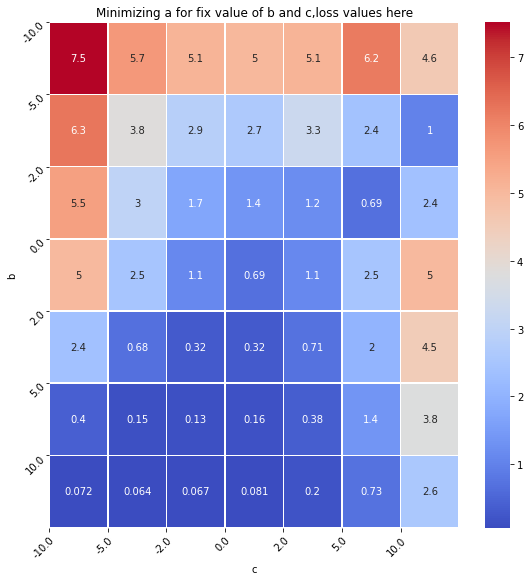

In [50]:
import seaborn as sns

fig = plt.figure(figsize=(8,8))
ax = sns.heatmap( loss_heat_map , linewidth = 0.5 , cmap = 'coolwarm' ,annot=True)


ax.set_xticks(np.arange(len(c)))
ax.set_yticks(np.arange(len(b)))

ax.set_xticklabels(c)
ax.set_yticklabels(b)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.xlabel("c")
plt.ylabel("b")
# for i in range(len(b)):
#     for j in range(len(c)):
#         text = ax.text(j, i, loss_heat_map[i, j],
#                         color="w",)
fig.tight_layout() 
plt.title("Minimizing a for fix value of b and c,loss values here")

In [51]:
a_value_heat_map = np.zeros((7,7))

In [52]:
a_value_heat_map[0,:] = df_test[df_test.init_b == -10].final_a
a_value_heat_map[1,:] = df_test[df_test.init_b == -5].final_a
a_value_heat_map[2,:] = df_test[df_test.init_b == -2].final_a
a_value_heat_map[3,:] = df_test[df_test.init_b == 0].final_a
a_value_heat_map[4,:] = df_test[df_test.init_b == 2].final_a
a_value_heat_map[5,:] = df_test[df_test.init_b == 5].final_a
a_value_heat_map[6,:] = df_test[df_test.init_b == 10].final_a

In [53]:
a_value_heat_map

array([[-4.49 , -4.477, -4.453, -4.418, -4.345, -0.898, -0.621],
       [-4.035, -4.03 , -3.991, -3.894, -1.006, -0.609, -0.05 ],
       [-3.417, -3.413, -3.354, -3.002, -0.506,  0.702,  1.913],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 1.967, -0.108, -1.056, -1.898, -2.596, -2.74 , -2.748],
       [-0.351, -0.999, -1.5  , -2.252, -2.864, -3.073, -3.101],
       [-0.991, -1.396, -1.828, -2.503, -2.997, -3.247, -3.359]])

Text(0.5, 1.0, 'Minimizing a for fix value of b and c,final a values here')

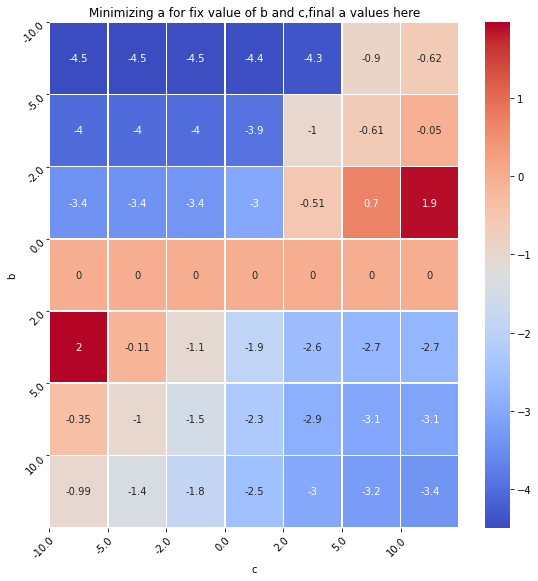

In [54]:
fig = plt.figure(figsize=(8,8))
ax = sns.heatmap( a_value_heat_map , linewidth = 0.5 , cmap = 'coolwarm' ,annot=True)


ax.set_xticks(np.arange(len(c)))
ax.set_yticks(np.arange(len(b)))

ax.set_xticklabels(c)
ax.set_yticklabels(b)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.xlabel("c")
plt.ylabel("b")

# for i in range(len(b)):
#     for j in range(len(c)):
#         text = ax.text(j, i, loss_heat_map[i, j],
#                         color="w",)
fig.tight_layout() 
plt.title("Minimizing a for fix value of b and c,final a values here")